In [10]:
import os
import pickle
import numpy as np
import tensorflow as tf
import math
import skimage as ski
import skimage.io
import matplotlib.pyplot as plt
import time
from confusion_matrix import get_confusion_matrix
from confusion_matrix import eval_AP
from confusion_matrix import eval_perf_multi

In [11]:
# Parameters
learning_policy = {1:1e-1, 3:1e-2, 5:1e-3, 7:1e-4, 9:1e-5}
training_iters = 200000
batch_size = 100
max_epochs = 20
print_every_num_batches = 20
draw_filter = 100
wd = 0

# Network Parameters
n_channel = 3
input_shape = [None, 32, 32, 3]
n_classes = 10

# tf Graph input

In [12]:
def shuffle_data(data_x, data_y):
    indices = np.arange(data_x.shape[0])
    np.random.shuffle(indices)
    shuffled_data_x = np.ascontiguousarray(data_x[indices])
    shuffled_data_y = np.ascontiguousarray(data_y[indices])
    return shuffled_data_x, shuffled_data_y

def unpickle(file):
    fo = open(file, 'rb')
    dict_ = pickle.load(fo)
    fo.close()
    return dict_

DATA_DIR = './CIFAR'
SAVE_DIR = './tensorflow_cifar'

img_height =32
img_width =32
num_channels=3

train_x = np.ndarray((0, img_height * img_width * num_channels), dtype=np.float32)
train_y = []
for i in range(1, 6):
    subset = unpickle(os.path.join(DATA_DIR, 'data_batch_%d' % i))
    train_x = np.vstack((train_x, subset['data']))
    train_y += subset['labels']
train_x = train_x.reshape((-1, num_channels, img_height, img_width)).transpose(0,2,3,1)
train_y = np.array(train_y, dtype=np.int32)

subset = unpickle(os.path.join(DATA_DIR, 'test_batch'))
test_x = subset['data'].reshape((-1, num_channels, img_height, img_width)).transpose(0,2,3,1).astype(np.float32)
test_y = np.array(subset['labels'], dtype=np.int32)

valid_size = 5000
train_x, train_y = shuffle_data(train_x, train_y)
valid_x = train_x[:valid_size, ...]
valid_y = train_y[:valid_size, ...]
train_x = train_x[valid_size:, ...]
train_y = train_y[valid_size:, ...]
data_mean = train_x.mean((0,1,2))
data_std = train_x.std((0,1,2))

train_x = (1.*train_x - data_mean) / data_std
valid_x = (1.*valid_x - data_mean) / data_std
test_x = (1.*test_x - data_mean) / data_std

(45000, 32, 32, 3)


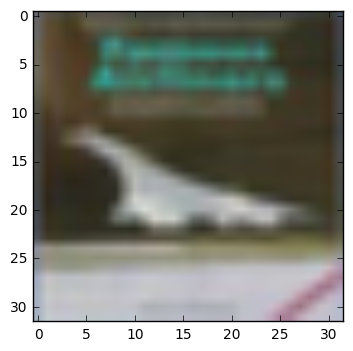

In [13]:
import matplotlib.pyplot as plt
print train_x.shape
plt.imshow(test_x[3]*data_std + data_mean)
plt.show()

In [14]:
def draw_conv_filters(epoch, step, weights, save_dir):
    w = weights.copy()
    num_filters = w.shape[3]
    num_channels = w.shape[2]
    k = w.shape[0]
    assert w.shape[0] == w.shape[1]
    w = w.reshape(k, k, num_channels, num_filters)
    w -= w.min()
    w /= w.max()
    border = 1
    cols = 8
    rows = math.ceil(num_filters / cols)
    width = cols * k + (cols-1) * border
    height = rows * k + (rows-1) * border
    img = np.zeros([height, width, num_channels])
    for i in range(num_filters):
        r = int(i / cols) * (k + border)
        c = int(i % cols) * (k + border)
        img[r:r+k,c:c+k,:] = w[:,:,:,i]
    filename = 'epoch_%02d_step_%06d.png' % (epoch, step)
    ski.io.imsave(os.path.join(save_dir, filename), img)

In [15]:
def plot_training_progress(save_dir, data):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))

    linewidth = 2
    legend_size = 10
    train_color = 'm'
    val_color = 'c'

    num_points = len(data['train_loss'])
    x_data = np.linspace(1, num_points, num_points)
    ax1.set_title('Cross-entropy loss')
    ax1.plot(x_data, data['train_loss'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
    ax1.plot(x_data, data['valid_loss'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
    ax1.legend(loc='upper right', fontsize=legend_size)
    ax2.set_title('Average class accuracy')
    ax2.plot(x_data, data['train_acc'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
    ax2.plot(x_data, data['valid_acc'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
    ax2.legend(loc='upper left', fontsize=legend_size)
    ax3.set_title('Learning rate')
    ax3.plot(x_data, data['lr'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='learning_rate')
    ax3.legend(loc='upper left', fontsize=legend_size)

    save_path = os.path.join(save_dir, 'training_plot.pdf')
    print('Plotting in: ', save_path)
    plt.savefig(save_path)

In [48]:
def evaluate(pred, cost, data_x, data_y):
    possible_labels = np.array(range(n_classes))
    for i in range(100,1,-1):
        if data_x.shape[0]%i==0:
            max_i = i
    
    predictions = None
    loss = 0
    for i in range(data_x.shape[0]/max_i):
        preds = sess.run(pred, feed_dict={ x: data_x[i*max_i:(i+1)*max_i]})
        loss += sess.run(cost, feed_dict={x: data_x[i*max_i:(i+1)*max_i], y: data_y[i*max_i:(i+1)*max_i]})*max_i
        if predictions == None:
            predictions = preds
        else:
            predictions = np.vstack((predictions,preds))
    loss/= data_x.shape[0]
    #print predictions.shape, max_i, i, data_y.shape
    mat = get_confusion_matrix(np.argmax(predictions,axis=1),np.argmax(data_y,axis=1),possible_labels,False)
    accuracy, prec, rec = eval_perf_multi(mat)
    #print accuracy
    #print '\n'.join(map(str,list(zip(map(lambda x: "Class: "+str(x),range(0,10)), \
    #                             map(lambda x: "Recall: "+str(x),rec), \
    #                             map(lambda x: "Precision: "+str(x),prec)))))
    return  loss, accuracy

In [17]:
# Store layers weight & bias
weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, n_channel, 16])),
    'wc2': tf.Variable(tf.random_normal([5, 5, 16, 32])),
    'wd1': tf.Variable(tf.random_normal([8*8*32, 256])),
    'wd2': tf.Variable(tf.random_normal([256, 128])),
    'out': tf.Variable(tf.random_normal([128, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([16])),
    'bc2': tf.Variable(tf.random_normal([32])),
    'bd1': tf.Variable(tf.random_normal([256])),
    'bd2': tf.Variable(tf.random_normal([128])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [18]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2, stride=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, stride, stride, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases):#,dropout):
    # Reshape input picture
    #x = tf.reshape(x, shape=[-1, 32, 32, 3])
    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=3, stride =2)
    
    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=3, stride=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    #fc1 = tf.nn.dropout(fc1, dropout)
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)

    # Output, class prediction
    out = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    return out

In [19]:
# Construct model
x = tf.placeholder(tf.float32, input_shape)
y = tf.placeholder(tf.float32, [None, n_classes])
pred = conv_net(x, weights, biases)

# Define loss and optimizer
cost = (tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))) 
#                       + tf.mul(tf.nn.l2_loss(weights['wc1']), wd)
#                       + tf.mul(tf.nn.l2_loss(weights['wc2']), wd)
#                       + tf.mul(tf.nn.l2_loss(weights['wd1']), wd)
#                       + tf.mul(tf.nn.l2_loss(weights['wd2']), wd)))


learning_rate = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.initialize_all_variables()

In [49]:
def labels_to_one_hot(Y,C):
    Yoh_ = np.zeros((Y.shape[0],C))
    Yoh_[range(Y.shape[0]),Y] = 1
    return Yoh_

with tf.device('/gpu:0'):
    sess = tf.Session()
    sess.run(init)
    plot_data = {}
    plot_data['train_loss'] = []
    plot_data['valid_loss'] = []
    plot_data['train_acc'] = []
    plot_data['valid_acc'] = []
    plot_data['lr'] = []

    num_examples = train_x.shape[0]
    num_batches = num_examples/batch_size
    #logits = pred
    #loss = cost
    #train_op = optimizer

    for epoch_num in range(1, max_epochs + 1):
        train_x, train_y = shuffle_data(train_x, train_y)
        for step in range(num_batches):
            offset = step * batch_size 
            # s ovim kodom pazite da je broj primjera djeljiv s batch_size
            batch_x = train_x[offset:(offset + batch_size), ...]
            batch_y = train_y[offset:(offset + batch_size)]
            batch_y = labels_to_one_hot(np.array(batch_y),n_classes)
            feed_dict = {x: batch_x, y: batch_y, learning_rate: 0.05}
            start_time = time.time()
            run_ops = [optimizer, cost, pred]
            ret_val = sess.run(run_ops, feed_dict=feed_dict)
            _, loss_val, logits_val = ret_val
            duration = time.time() - start_time
            if (step+1) % 50 == 0:
                sec_per_batch = float(duration)
                format_str = 'epoch %d, step %d / %d, loss = %.2f (%.3f sec/batch)'
                print format_str % (epoch_num, step+1, num_batches, loss_val, sec_per_batch)

        train_loss, train_acc = evaluate(pred, cost, train_x, labels_to_one_hot(np.array(train_y),n_classes))
        print 'Train loss: %s , train acc: %s' %(train_loss, train_acc)

        valid_loss, valid_acc = evaluate(pred, cost, valid_x, labels_to_one_hot(np.array(valid_y),n_classes))
        print 'Validation loss: %s, validation acc: %s' %(valid_loss, valid_acc) 

        plot_data['train_loss'] += [train_loss]
        plot_data['valid_loss'] += [valid_loss]
        plot_data['train_acc'] += [train_acc]
        plot_data['valid_acc'] += [valid_acc]
        #plot_data['lr'] += [lr.eval(session=sess)]
        plot_data['lr'] += [0]
        plot_training_progress(SAVE_DIR, plot_data)

epoch 1, step 50 / 450, loss = 3.05 (0.027 sec/batch)
epoch 1, step 100 / 450, loss = 2.41 (0.027 sec/batch)
epoch 1, step 150 / 450, loss = 2.44 (0.027 sec/batch)
epoch 1, step 200 / 450, loss = 2.36 (0.027 sec/batch)
epoch 1, step 250 / 450, loss = 2.48 (0.027 sec/batch)
epoch 1, step 300 / 450, loss = 2.63 (0.027 sec/batch)
epoch 1, step 350 / 450, loss = 2.44 (0.027 sec/batch)
epoch 1, step 400 / 450, loss = 2.40 (0.027 sec/batch)
epoch 1, step 450 / 450, loss = 3.32 (0.027 sec/batch)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Train loss: 3.12368775913 , train acc: 0.100088888889
Validation loss: 3.05924732628, validation acc: 0.0998
('Plotting in: ', './tensorflow_cifar/training_plot.pdf')
epoch 2, step 50 / 450, loss = 2.31 (0.027 sec/batch)
epoch 2, step 100 / 450, loss = 2.89 (0.027 sec/batch)
epoch 2, step 150 / 450, loss = 2.85 (0.027 sec/batch)
epoch 2, step 200 / 450, loss = 2.44 (0.027 sec/batch)
epoch 2, step 250 / 450, loss = 2.44 (0.027 sec/batch)
epoch 2, step 300 / 450, loss = 2.99 (0.027 sec/batch)
epoch 2, step 350 / 450, loss = 3.01 (0.027 sec/batch)
epoch 2, step 400 / 450, loss = 2.68 (0.027 sec/batch)
epoch 2, step 450 / 450, loss = 11.53 (0.027 sec/batch)
Train loss: 2.86236022249 , train acc: 0.0994222222222
Validation loss: 2.91849048882, validation acc: 0.1062
('Plotting in: ', './tensorflow_cifar/training_plot.pdf')
epoch 3, step 50 / 450, loss = 2.40 (0.027 sec/batch)
epoch 3, step 100 / 450, loss = 3.32 (0.027 sec/batch)
epoch 3, step 150 / 450, loss = 3.45 (0.027 sec/batch)
epoch 

In [17]:
def labels_to_one_hot(Y,C):
    Yoh_ = np.zeros((Y.shape[0],C))
    Yoh_[range(Y.shape[0]),Y] = 1
    return Yoh_

sess = tf.Session()
sess.run(init)
step = 1
Yoh_ = labels_to_one_hot(np.array(test_y),n_classes)
num_examples = train_x.shape[0]
num_batches = num_examples/batch_size
for epoch in range(1, max_epochs):
    if epoch in learning_policy:
        lr = learning_policy[epoch]
    
    train_x,train_y = shuffle_data(train_x,train_y)
    for i in range (num_batches):
        batch_x = train_x[i*batch_size:(i+1)*batch_size,:,:,:]
        batch_y = labels_to_one_hot(np.array(train_y[i*batch_size:(i+1)*batch_size]), n_classes)
        _, loss, acc= sess.run([optimizer,cost, accuracy], feed_dict={x: batch_x, y: batch_y, learning_rate: 0.01})
        if i % print_every_num_batches ==0:
            print "Epoch %d, step %d/%d, batch loss = %.2f batch_acc = %s, acc = %s" % (epoch, i*batch_size, num_examples, loss, acc, sess.run(accuracy, feed_dict={x:test_x, y: Yoh_ }))
        if i % draw_filter == 0:
            draw_conv_filters(epoch, i*batch_size, sess.run(weights['wc1']), save_dir)
            
print "Testing Accuracy:", sess.run(accuracy, feed_dict={x: test_x,
                                  y: labels_to_one_hot(test_y,n_classes)})

Epoch 1, step 0/45000, batch loss = 724672.00 batch_acc = 0.11, acc = 0.0937


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Epoch 1, step 2000/45000, batch loss = 51548.07 batch_acc = 0.18, acc = 0.1536
Epoch 1, step 4000/45000, batch loss = 26684.28 batch_acc = 0.18, acc = 0.1831
Epoch 1, step 6000/45000, batch loss = 20324.92 batch_acc = 0.19, acc = 0.2138
Epoch 1, step 8000/45000, batch loss = 14760.72 batch_acc = 0.13, acc = 0.2211
Epoch 1, step 10000/45000, batch loss = 10037.49 batch_acc = 0.15, acc = 0.2272
Epoch 1, step 12000/45000, batch loss = 7021.56 batch_acc = 0.25, acc = 0.2275
Epoch 1, step 14000/45000, batch loss = 5544.26 batch_acc = 0.25, acc = 0.2344


KeyboardInterrupt: 

In [33]:
print sess.run(correct_pred, feed_dict={x: [train_x[0]],y: labels_to_one_hot(np.reshape(train_y[0],(-1,1)),n_classes)})
from collections import Counter
#print np.reshape(train_y[0:50],(-1,1))
print n_classes
print labels_to_one_hot(np.array(train_y[i*5:(i+1)*5]),n_classes)
print labels_to_one_hot(train_y[i*5:(i+1)*5],n_classes)
print Counter(test_y).most_common()

[False]
10
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]
[(0, 1000), (1, 1000), (2, 1000), (3, 1000), (4, 1000), (5, 1000), (6, 1000), (7, 1000), (8, 1000), (9, 1000)]


In [42]:
size = 3
stride = 2
w = 32
h = 32
w = (1.*w-size)/stride +1
h = (1.*h-size)/stride +1 
print w,h
w = (1.*w-size)/stride +1
h = (1.*h-size)/stride +1
print w,h

15.5 15.5
7.25 7.25


In [ ]:
size = 3
stride = 2
w = 4
h = 4
w = ((w-1)*stride)+size
h = ((h-1)*stride)+size
print w,h
w = ((w-1)*stride)+size
h = ((h-1)*stride)+size
print w,h